In [1]:
%matplotlib inline

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nighres.io import io_mesh
import gdist
import pickle
from brainsmash.mapgen.memmap import txt2memmap
from brainsmash.mapgen.sampled import Sampled
from brainsmash.mapgen.eval import sampled_fit

In [3]:
data_dir = '/home/julia/data/gradients/'

### Create Geodesic distance map inside cortex mask

In [16]:
mesh = io_mesh.load_mesh(data_dir+'results/embedding/embed_sampled_mesh.vtk')
cortex = np.where(mesh['data'][:,0]!=0)[0]
np.save(data_dir+'results/null_models/surface/cortex_mask.npy', cortex)
np.save('/home/julia/data/gradients/results/null_models/surface/points.npy', mesh['points'])
np.save('/home/julia/data/gradients/results/null_models/surface/faces.npy', mesh['faces'])

In [18]:
cortex = np.load(data_dir+'results/null_models/surface/cortex_mask.npy')

In [ ]:
cortex = np.load(data_dir+'results/null_models/surface/cortex_mask.npy')
points = np.load(data_dir+'results/null_models/surface/points.npy')
faces = np.load(data_dir+'results/null_models/surface/faces.npy')

In [ ]:
for idx in range(cortex.shape[0]-1)
    dist = gdist.compute_gdist(np.array(points, dtype=np.float64),
                               np.array(faces, dtype=np.int32),
                               source_indices=np.array([cortex[idx]], dtype=np.int32),
                               target_indices=np.array(cortex[idx+1:], dtype=np.int32))

    np.save(data_dir+'results/null_models/surface/iter/idx_{}.npy'.format(idx), dist)

In [11]:
dist_matrix = np.zeros(shape=(cortex.shape[0],cortex.shape[0]))
for r in range(cortex.shape[0]-1):
    dist_matrix[r, r+1:] = np.load(data_dir+'results/null_models/surface/iter/idx_{}.npy'.format(r))
dist_matrix += dist_matrix.T

In [17]:
np.savetxt(data_dir+'results/null_models/surface/geodesic_dist_matrix.txt', dist_matrix)

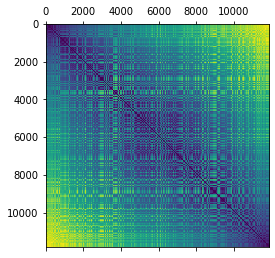

In [13]:
plt.matshow(dist_matrix)

### Create memory mapped arrays for surrogates

In [5]:
output_files = txt2memmap(data_dir+"results/null_models/surface/geodesic_dist_matrix.txt", 
                          data_dir+"results/null_models/surface/", 
                          maskfile=None, delimiter=' ')

### Check and combine surrogates ran on cluster

In [74]:
# Load, reshape and save
for z in range(6):
    surrogates = []
    emp_var_samples = []
    surr_var_samples = []
    u0_samples = []
    for n in range(10):
        surr_dict = pickle.load(open(data_dir+'results/null_models/surface/surrogates/surf{}_n{}.pkl'.format(z,n), 'rb'))
        surrogates.append(surr_dict['maps'])
        emp_var_samples.append(surr_dict['emp_var'])
        surr_var_samples.append(surr_dict['surr_var'])
        u0_samples.append(surr_dict['u0'])


    emp_var_samples = np.asarray(emp_var_samples).reshape(10000,25)
    surr_var_samples = np.asarray(surr_var_samples).reshape(10000,25)
    u0_samples = np.asarray(u0_samples).reshape(10000,25)
    surrogates = np.asarray(surrogates).reshape(10000, 11847)
    
    np.save(data_dir+'results/null_models/surface/surrogates/surf{}_emp_var.npy'.format(z), emp_var_samples)
    np.save(data_dir+'results/null_models/surface/surrogates/surf{}_surr_var.npy'.format(z), surr_var_samples)
    np.save(data_dir+'results/null_models/surface/surrogates/surf{}_u0.npy'.format(z), u0_samples)
    np.save(data_dir+'results/null_models/surface/surrogates/surf{}_surrogates.npy'.format(z), surrogates)

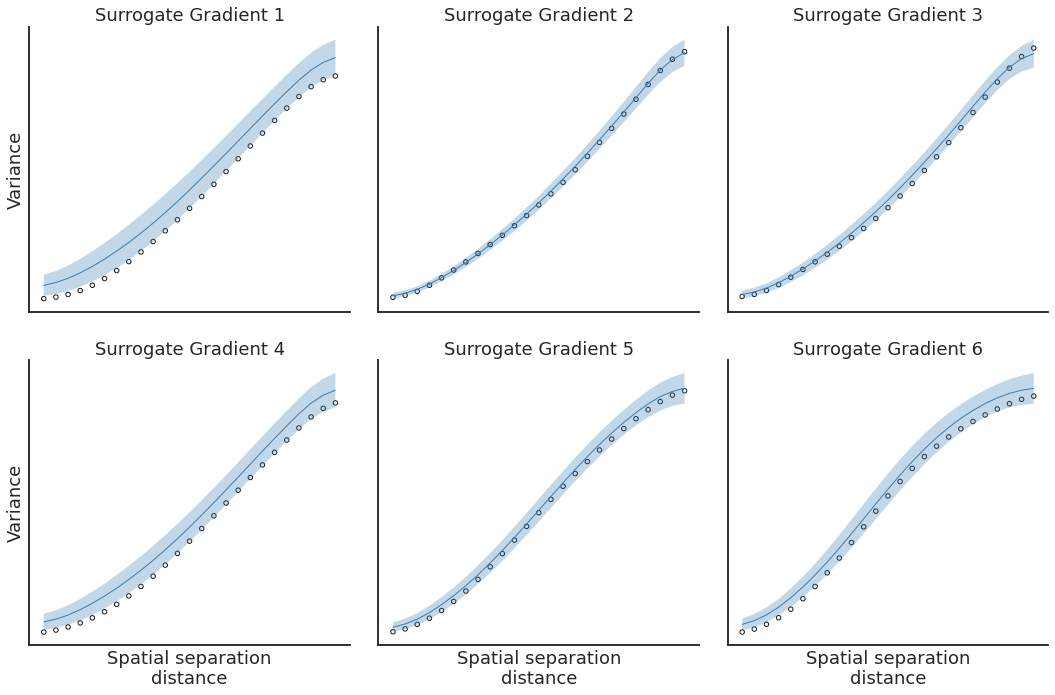

In [75]:
# Plot variograms
sns.set_style('ticks')
sns.set_context('talk')
fig = plt.figure(figsize=(15, 10))

for z in range(6):
    
    emp_var_samples = np.load(data_dir+'results/null_models/surface/surrogates/surf{}_emp_var.npy'.format(z))
    surr_var_samples = np.load(data_dir+'results/null_models/surface/surrogates/surf{}_surr_var.npy'.format(z))
    u0_samples = np.load(data_dir+'results/null_models/surface/surrogates/surf{}_u0.npy'.format(z))

    emp_var = emp_var_samples.mean(axis=0)
    u0 =  u0_samples.mean(axis=0)
    mu = surr_var_samples.mean(axis=0)
    sigma = surr_var_samples.std(axis=0)
    
    ax = fig.add_subplot(2,3,z+1)
    ax.scatter(u0, emp_var, s=20, facecolor='none', edgecolor='k',marker='o', lw=1, label='Empirical')
    ax.fill_between(u0, mu-sigma, mu+sigma, facecolor='#377eb8',edgecolor='none', alpha=0.3)
    ax.plot(u0, mu, color='#377eb8', label='SA-preserving', lw=1)
    plt.xticks([])
    plt.yticks([])
    
    if z in [0,3]:
        plt.ylabel("Variance")
    if z>2:
        plt.xlabel("Spatial separation\ndistance")
    if z==6:
        leg = ax.legend(loc=0)
    plt.title('Surrogate Gradient {}'.format(z+1))
    sns.despine()
    plt.tight_layout()